# <br>Question 3

#### a)  Is the Closing price a stationary time series? Perform Augmented Dickey Fuller test to verify.  If not, convert to stationary using ordered differences. 
### Analysis:

In [1]:
from pandas import Series
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf

In [2]:
data = pd.read_csv("StockTrain.csv")
data["date"] = [a[:10] for a in data.date]
data = pd.read_csv('StockTrain.csv', parse_dates=['date'], index_col='date')
ts = data['close']

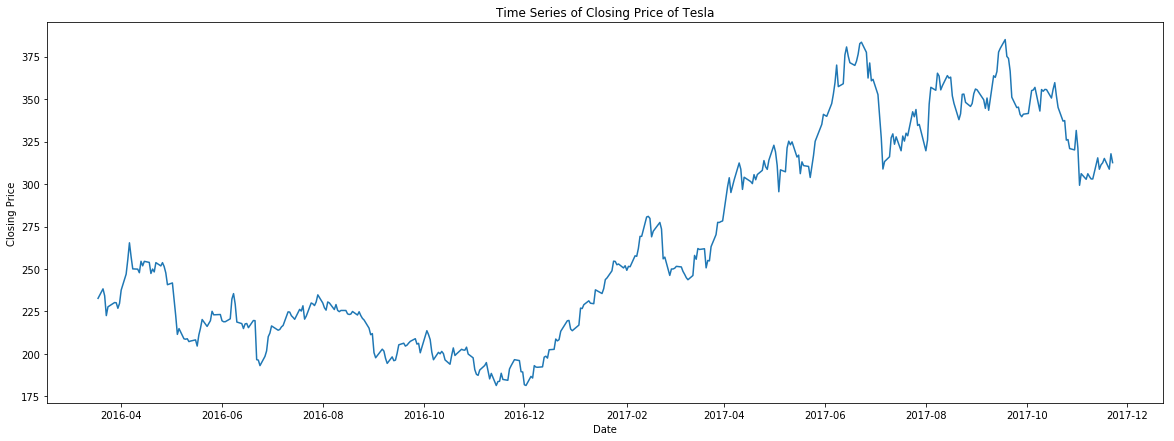

In [3]:
plt.figure(figsize=(20,7))
plt.plot(ts)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Time Series of Closing Price of Tesla")
plt.show()

In [4]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print("Strandard deviation of Rolling mean", np.std(rolmean))
    print("Strandard deviation of Rolling Standard dev", np.std(rolstd))
    
    #Dickey-Fuller Test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

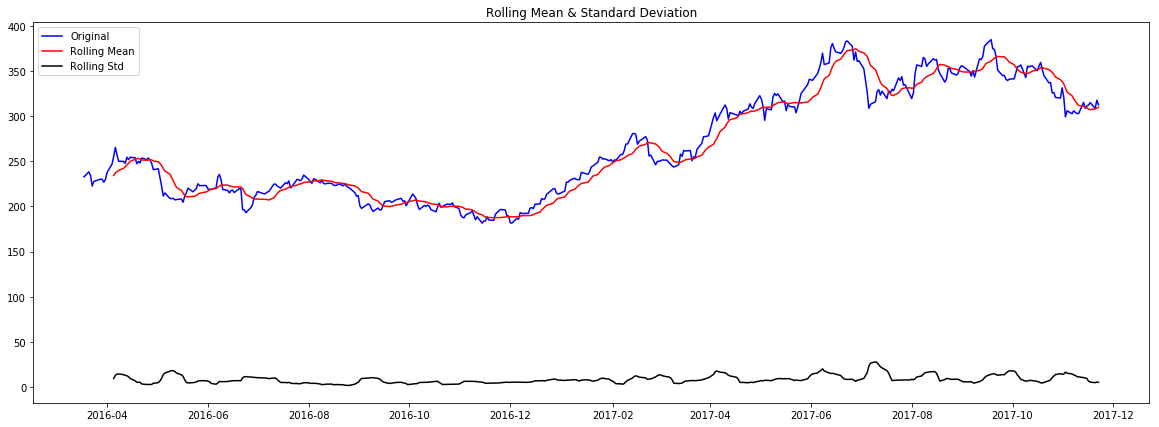

('Strandard deviation of Rolling mean', 59.573970283105645)
('Strandard deviation of Rolling Standard dev', 4.494872036297583)
Results of Dickey-Fuller Test:
Test Statistic                  -1.038220
p-value                          0.739070
#Lags Used                       3.000000
Number of Observations Used    422.000000
Critical Value (5%)             -2.868413
Critical Value (1%)             -3.445941
Critical Value (10%)            -2.570431
dtype: float64


In [5]:
test_stationarity(ts)

#### Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series.
#### Also using the Dickey-Fuller test we can see:
#### that the test statistic is above 10% critical value
#### P-value is 0.739070 i.e greater than 0.05
#### Thus we Can say for sure that 'Closing Price' is not a stationary time series.

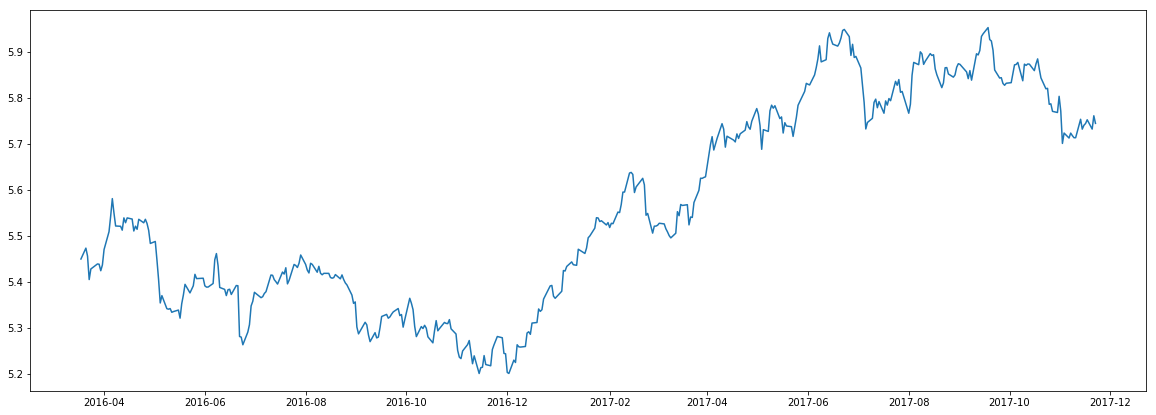

In [6]:
# Taking log for ease
ts_log = np.log(ts)
plt.figure(figsize=(20,7))
plt.plot(ts_log)
plt.show()

### <br> Making stationary:

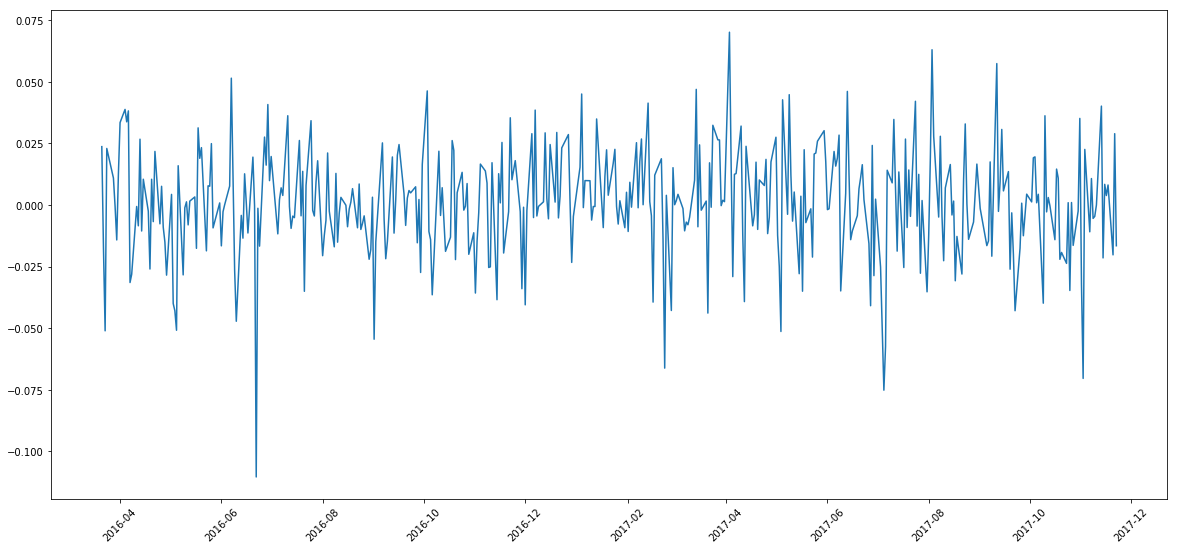

In [7]:
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize = (20, 9))
plt.plot(ts_log_diff)
plt.xticks(rotation = 45)
plt.show()

#### This appears to have reduced trend considerably. Lets verify using our plots:

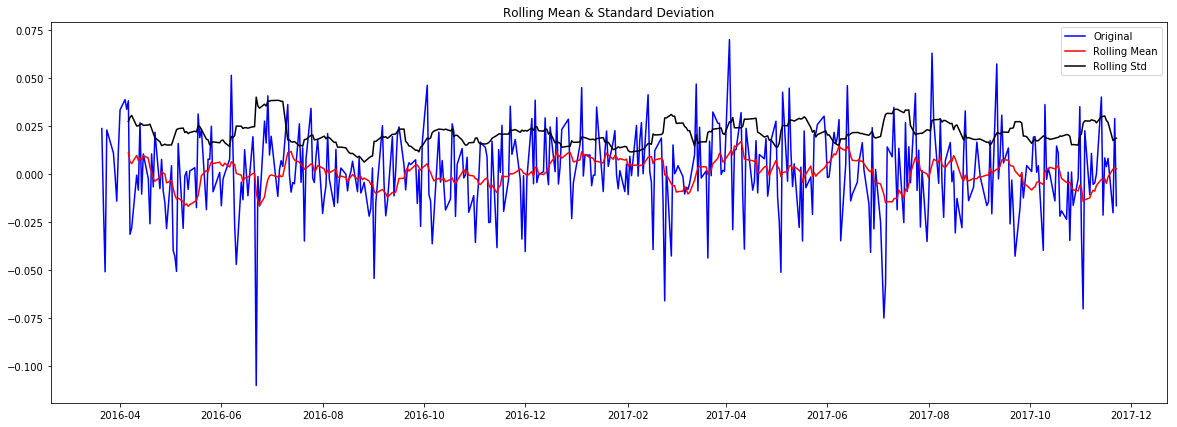

('Strandard deviation of Rolling mean', 0.006653916513556771)
('Strandard deviation of Rolling Standard dev', 0.005834420008074018)
Results of Dickey-Fuller Test:
Test Statistic                -1.261335e+01
p-value                        1.636939e-23
#Lags Used                     2.000000e+00
Number of Observations Used    4.220000e+02
Critical Value (5%)           -2.868413e+00
Critical Value (1%)           -3.445941e+00
Critical Value (10%)          -2.570431e+00
dtype: float64


In [8]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

#### Here we can see from the statistics that both, mean and std are not varying significantly and also the p values id greater than 0.05, thus eliminating the possibility of rejecting H0. Also the test statistic is less than 1% critical value, thus we have 99% confidence that this is stationary time series.

#### (ii) Remove Seasonality,and plot ACF and PACF plots and get the best parameter (using RMSE) for SARIMAXmodel for the AIC metric.

### Decomposition:

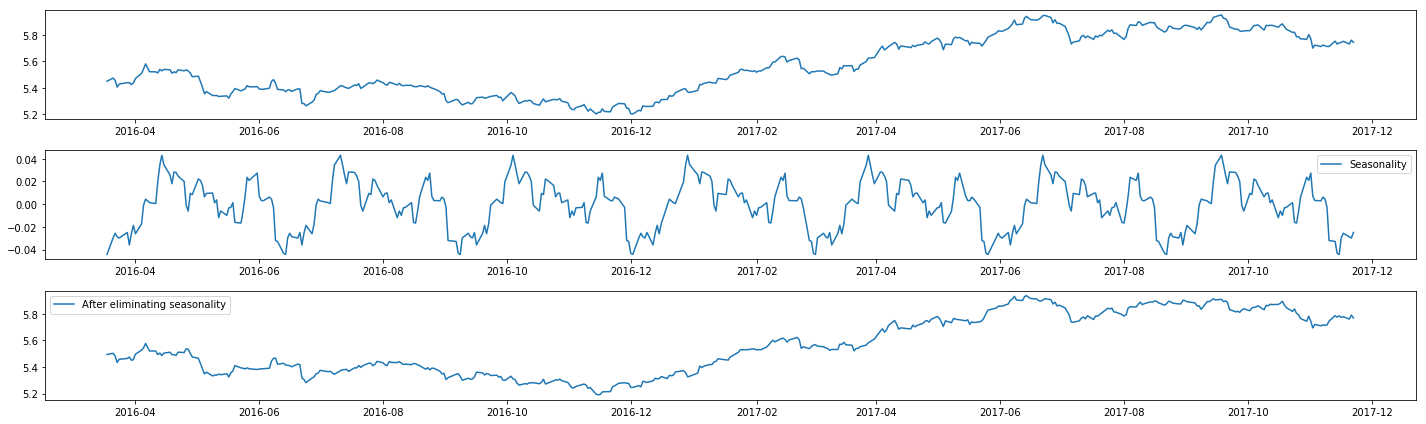

In [9]:
# assuming that the data repeats that freq is 2 months, i.e. 60 days approx.
decomposition = seasonal_decompose(ts_log, freq=60)

seasonal = decomposition.seasonal

plt.figure(figsize = (20, 6))
plt.subplot(311)
plt.plot(ts_log, label='Original')

plt.subplot(312)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(313)
neg_seasonality = ts_log-seasonal
plt.plot(neg_seasonality, label='After eliminating seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

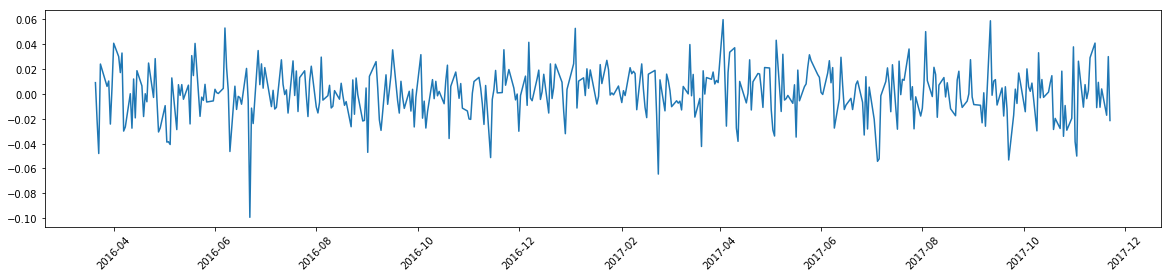

In [10]:
#Utility for later
neg_seasonality_diff = neg_seasonality - neg_seasonality.shift()
neg_seasonality_diff.dropna(inplace = True)
plt.figure(figsize = (20, 4))
plt.plot(neg_seasonality_diff)
plt.xticks(rotation = 45)
plt.show()

### ACF and PACF

In [11]:
lag_acf = acf(neg_seasonality_diff, nlags=20)
lag_pacf = pacf(neg_seasonality_diff, nlags=20, method='ols')

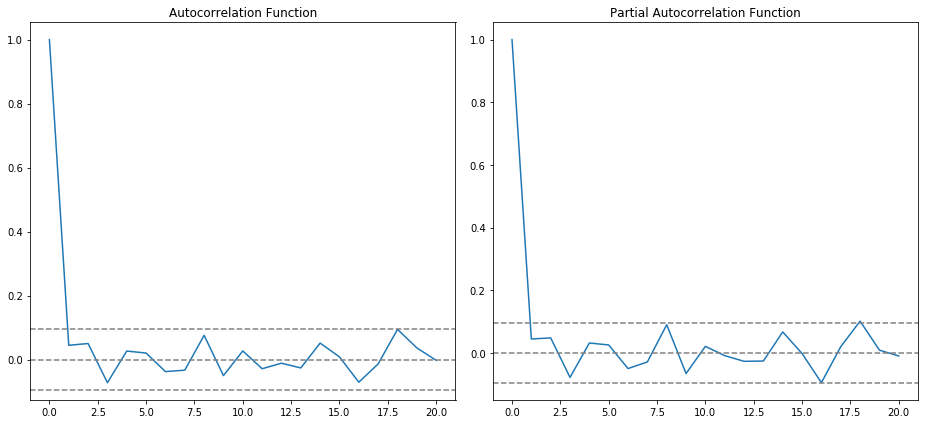

In [12]:
#Plot ACF: 
plt.figure(figsize = (13, 6))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(neg_seasonality_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(neg_seasonality_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(neg_seasonality_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(neg_seasonality_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

# fig = plt.figure(figsize=(10,10))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(ts_diff.dropna(), lags=40, ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(ts_diff.dropna(), lags=40, ax=ax2)
# plt.show()

/home/ishita/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


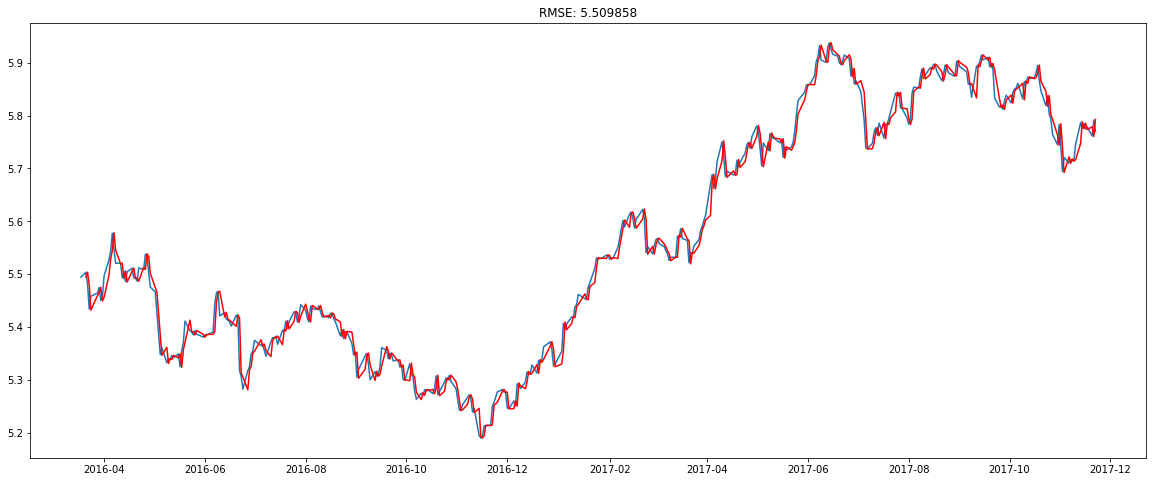

                           Statespace Model Results                           
Dep. Variable:                  close   No. Observations:                  426
Model:               SARIMAX(1, 1, 0)   Log Likelihood                1056.758
Date:                Tue, 30 Oct 2018   AIC                          -2109.517
Time:                        16:08:01   BIC                          -2101.413
Sample:                             0   HQIC                         -2106.315
                                - 426                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0457      0.049      0.939      0.348      -0.050       0.141
sigma2         0.0004   2.16e-05     18.724      0.000       0.000       0.000
Ljung-Box (Q):                       35.66   Jarque-

In [13]:
#AR
model = sarimax.SARIMAX(neg_seasonality, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.figure(figsize = (20, 8))
plt.plot(neg_seasonality)
plt.plot(results_AR.fittedvalues[1:], color='red')
plt.title('RMSE: %f'% np.sqrt(sum((results_AR.fittedvalues-neg_seasonality)**2)))
plt.show()
print (results_AR.summary())

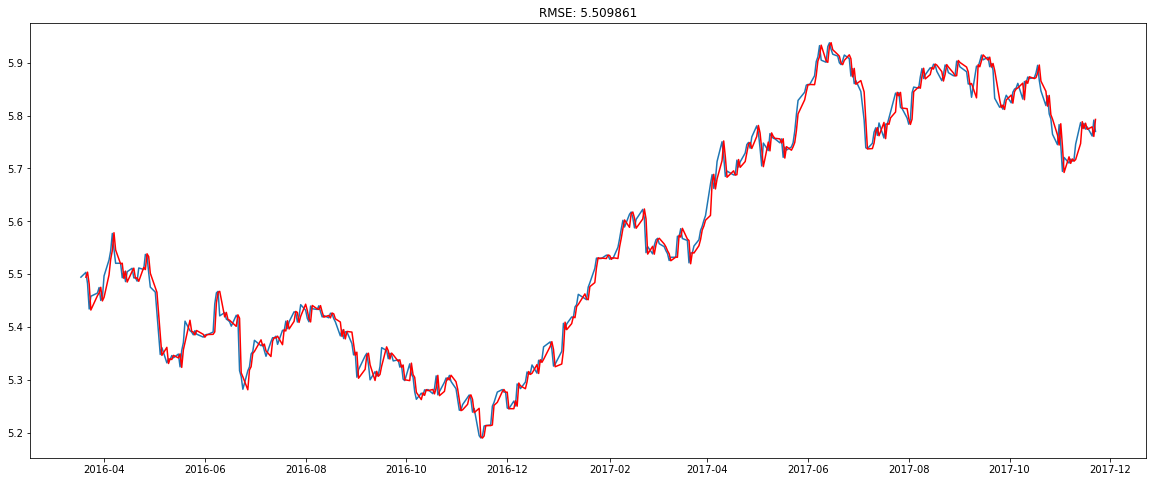

                           Statespace Model Results                           
Dep. Variable:                  close   No. Observations:                  426
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1056.716
Date:                Tue, 30 Oct 2018   AIC                          -2109.432
Time:                        12:13:46   BIC                          -2101.323
Sample:                    03-18-2016   HQIC                         -2106.229
                         - 11-22-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0423      0.049      0.865      0.387      -0.054       0.138
sigma2         0.0004   2.17e-05     18.665      0.000       0.000       0.000
Ljung-Box (Q):                       35.68   Jarque-

In [121]:
#MA
model = sarimax.SARIMAX(neg_seasonality, order=(0, 1, 1))  
results_MA = model.fit(disp=-1) 
plt.figure(figsize = (20, 8))
plt.plot(neg_seasonality)
plt.plot(results_MA.fittedvalues[1:], color='red')
plt.title('RMSE: %f'% np.sqrt(sum((results_MA.fittedvalues-neg_seasonality)**2)))
plt.show()
print (results_MA.summary())

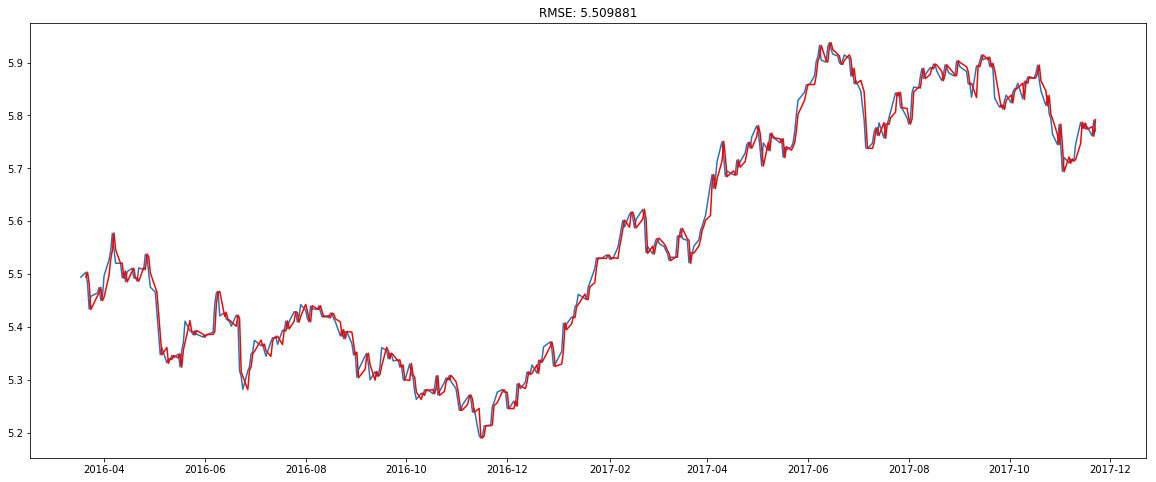

                           Statespace Model Results                           
Dep. Variable:                  close   No. Observations:                  426
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1056.448
Date:                Tue, 30 Oct 2018   AIC                          -2106.896
Time:                        12:13:54   BIC                          -2094.733
Sample:                    03-18-2016   HQIC                         -2102.091
                         - 11-22-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2531      1.894     -0.134      0.894      -3.966       3.459
ma.L1          0.2761      1.885      0.146      0.884      -3.418       3.970
sigma2         0.0004   2.19e-05     18.539      0.0

In [122]:
#Combined
model = sarimax.SARIMAX(neg_seasonality, order=(1, 1, 1))  
results = model.fit(disp=-1)  
plt.figure(figsize = (20, 8))
plt.plot(neg_seasonality)
plt.plot(results.fittedvalues[1:], color='red')
plt.title('RMSE: %f'% np.sqrt(sum((results.fittedvalues-neg_seasonality)**2)))
plt.show()
print (results.summary())

#### AR model gives the best result

In [19]:
test = pd.read_csv("StockTest.csv")
test["date"] = [a[:10] for a in test.date]
train = pd.read_csv('StockTrain.csv')
train["date"] = [a[:10] for a in train.date]



In [21]:
fit1 = sarima.SARIMAX(train.Count, order=(1, 1, 0)).fit()
forecast = fit1.predict(start = 0, end= 427, dynamic= True)
d = {'test':test['close'], 'forecast': forecast}
df = pd.DataFrame(d)
# forecast
df[['test', 'forecast']].plot(figsize=(12, 8))
plt.show()

NameError: name 'sarima' is not defined

/home/ishita/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/home/ishita/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.


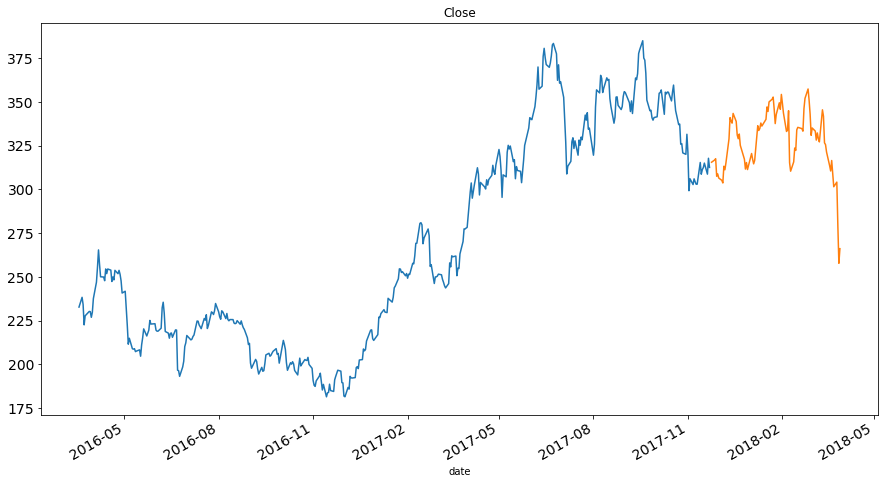

In [56]:
train = pd.read_csv('StockTrain.csv')
test = pd.read_csv('StockTest.csv')
test["date"] = [a[:10] for a in test.date]
train["date"] = [a[:10] for a in train.date]
#Aggregating the dataset at daily level
train.Timestamp = pd.to_datetime(train.date,format='%Y-%m-%d') 
train.index = train.Timestamp 
# train.index.freq = 'M'
# train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test.date,format='%Y-%m-%d') 
test.index = test.Timestamp 
# test.index.freq = 'D'
# test = test.resample('D').mean()
train.close.plot(figsize=(15,8), title= 'Close', fontsize=14)
test.close.plot(figsize=(15,8), title= 'Close', fontsize=14)
plt.show()

In [67]:
len(train.close)

426

In [73]:
x = test.copy()
print x
fit1 = sarimax.SARIMAX(train.close, order=(1,1,0)).fit()
x['SARIMA'] = fit1.predict(start="2017-11-24", end="2018-03-29",dynamic=True)
x['SARIMA']
# plt.figure(figsize=(16,8))
# plt.plot( train['close'], label='Train')
# plt.plot(test['close'], label='Test')
# plt.plot(x['SARIMA'], label='SARIMA')
# plt.legend(loc='best')
# plt.show()

                  date    close      volume    open      high       low
date                                                                   
2017-11-24  2017-11-24  315.550   3244065.0  313.79  316.4100  311.0000
2017-11-27  2017-11-27  316.810   4537779.0  313.25  317.3400  309.5100
2017-11-28  2017-11-28  317.550   4941703.0  316.36  320.0000  313.9200
2017-11-29  2017-11-29  307.540   8757463.0  317.30  318.0000  301.2300
2017-11-30  2017-11-30  308.850   4345434.0  308.56  310.7000  304.5400
2017-12-01  2017-12-01  306.530   4286082.0  305.44  310.3200  305.0500
2017-12-04  2017-12-04  305.200   5834227.0  306.50  308.2650  300.6100
2017-12-05  2017-12-05  303.700   4643708.0  302.00  308.0000  301.0000
2017-12-06  2017-12-06  313.260   7184477.0  300.10  313.3900  300.0000
2017-12-07  2017-12-07  311.240   4779590.0  312.00  318.6341  311.0500
2017-12-08  2017-12-08  315.130   3466088.0  314.60  316.9800  311.2600
2017-12-11  2017-12-11  328.910   7926090.0  314.63  329.0100  3

/home/ishita/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [22]:
r = model.predict(start="2016-03-18", end="2017-11-22", dynamic=True)
plt.plot(r, label='SARIMA')
plt.legend(loc='best')
plt.show()
plt.show()

TypeError: predict() takes at least 2 arguments (1 given)